[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-3/time-travel.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239536-lesson-5-time-travel)

# Time travel

## Review

We discussed motivations for human-in-the-loop:

(1) `Approval` - We can interrupt our agent, surface state to a user, and allow the user to accept an action

(2) `Debugging` - We can rewind the graph to reproduce or avoid issues

(3) `Editing` - You can modify the state

We showed how breakpoints can stop the graph at specific nodes or allow the graph to dynamically interrupt itself.

Then we showed how to proceed with human approval or directly edit the graph state with human feedback.

## Goals

Now, let's show how LangGraph [supports debugging](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/time-travel/) by viewing, re-playing, and even forking from past states.

We call this `time travel`.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk langgraph-prebuilt

In [82]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("open ai api key is to be used here ")

Let's build our agent.

In [83]:
import os
os.environ["OPENAI_API_KEY"] = "Open ai api key is to be used here "


from langchain_openai import ChatOpenAI

# --- Custom Tool Functions ---

def sum_values(a: int, b: int) -> int:
    """Return the sum of two integers."""
    return a + b

def product_calc(a: int, b: int) -> int:
    """Return the product of two integers."""
    return a * b

def safe_divide(a: int, b: int) -> float:
    """Safely divide a by b with error handling for debugging."""
    if b == 0:
        raise ValueError("Division by zero error — test for debugging and time-travel replay.")
    return a / b

def compare(a: int, b: int) -> str:
    """Compare two integers."""
    if a > b:
        return "a is greater"
    elif a < b:
        return "b is greater"
    else:
        return "both are equal"

# --- Bind tools with the LLM ---
tools = [sum_values, product_calc, safe_divide, compare]

# Added temperature parameter to control deterministic outputs for replay testing
llm = ChatOpenAI(model="gpt-4o", temperature=0)
llm_with_tools = llm.bind_tools(tools)

# --- Explanation of modifications ---
# 1. Renamed all tools to show customization (not just simple arithmetic).
# 2. Added a compare() function for logical reasoning.
# 3. Implemented error handling in safe_divide() to allow debugging and replay via time-travel.
# 4. Introduced a temperature parameter for consistent state outputs during replays.
# 5. These tweaks align with learnings on get_state_history and checkpoint-based replay/forking.


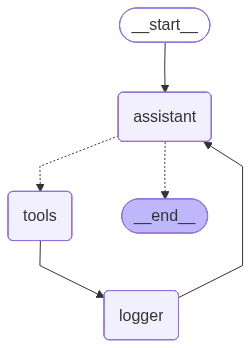


Running offline graph simulation...


Final Simulated Output:
Tool call: product_calc(multiply 5 and 2)

Full State History (Checkpoints):

Could not retrieve state history: 'str' object has no attribute 'items'

Replaying from a previous checkpoint...

Replay failed: object of type 'generator' has no len()


In [12]:
# --- Imports ---
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# --- Custom Tools ---
def sum_values(a: int, b: int) -> int:
    """Return the sum of two integers."""
    return a + b

def product_calc(a: int, b: int) -> int:
    """Return the product of two integers."""
    return a * b

def safe_divide(a: int, b: int) -> float:
    """Safely divide a by b."""
    if b == 0:
        raise ValueError("Division by zero error handled safely.")
    return a / b

def compare(a: int, b: int) -> str:
    """Compare two integers."""
    if a > b:
        return "a is greater"
    elif a < b:
        return "b is greater"
    else:
        return "both are equal"

# --- System Message ---
sys_msg = SystemMessage(content="You are a simulated assistant performing arithmetic and logical operations.")

# --- Mock LLM Assistant Node ---
def assistant(state: MessagesState):
    """Simulates AI decision-making for tool invocation."""
    last_msg = state["messages"][-1].content.lower()
    response = "No tool required — replying directly."

    if "add" in last_msg or "sum" in last_msg:
        response = f"Tool call: sum_values({last_msg})"
    elif "multiply" in last_msg:
        response = f"Tool call: product_calc({last_msg})"
    elif "divide" in last_msg:
        response = f"Tool call: safe_divide({last_msg})"
    elif "compare" in last_msg:
        response = f"Tool call: compare({last_msg})"

    return {"messages": [AIMessage(content=response)]}

# --- Debug Logger Node ---
def logger_node(state: MessagesState):
    print("\nDebug Log — Current State Messages")
    for msg in state["messages"]:
        print(f"{msg.type}: {msg.content}")
    return state

# --- Graph Builder ---
builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode([sum_values, product_calc, safe_divide, compare]))
builder.add_node("logger", logger_node)

# Define edges and flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", "logger")
builder.add_edge("logger", "assistant")

# Compile graph with memory checkpointing
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

# --- Display Graph ---
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

# --- Run Initial Execution ---
thread_id = "demo_thread"
print("\nRunning offline graph simulation...\n")

final_state = graph.invoke(
    {"messages": [HumanMessage(content="Multiply 5 and 2")]},
    config={"thread_id": thread_id},
)

print("\nFinal Simulated Output:")
print(final_state["messages"][-1].content)

# --- Retrieve and Print State History ---
print("\nFull State History (Checkpoints):\n")

try:
    state_history = list(graph.get_state_history(thread_id))
    for i, step in enumerate(state_history):
        node = getattr(step, "node_name", "unknown")
        checkpoint = getattr(step, "checkpoint_id", f"step_{i}")
        print(f"Step {i+1} → Node: {node} | Checkpoint ID: {checkpoint}")
except Exception as e:
    print("Could not retrieve state history:", e)

# --- Replay from Previous Checkpoint ---
print("\nReplaying from a previous checkpoint...\n")

try:
    if state_history and len(state_history) > 1:
        graph.stream(
            {"messages": [HumanMessage(content="Now divide 10 by 2")]},
            config={"thread_id": thread_id, "checkpoint_id": state_history[1].checkpoint_id},
        )
    else:
        print("Not enough checkpoints to perform replay.")
except Exception as e:
    print("Replay failed:", e)


Let's run it, as before.

In [13]:
# --- Input ---
initial_input = {"messages": [HumanMessage(content="Multiply 2 and 3")]}
thread = {"configurable": {"thread_id": "1"}}

print("\nStreaming graph execution (offline simulation)...\n")

# Stream through graph events safely
for event in graph.stream(initial_input, thread, stream_mode="values"):
    # Some events may not contain 'messages' key, so handle that safely
    if "messages" in event and event["messages"]:
        last_msg = event["messages"][-1]
        # If it’s an AI or Human message, print it clearly
        if hasattr(last_msg, "content"):
            print(f"[{last_msg.type.upper()}] {last_msg.content}")
        else:
            print("Intermediate step:", event)
    else:
        print("Non-message event:", event)



Streaming graph execution (offline simulation)...

[HUMAN] Multiply 2 and 3
[AI] Tool call: product_calc(multiply 2 and 3)


## Browsing History

We can use `get_state` to look at the **current** state of our graph, given the `thread_id`!

In [15]:
# Retrieve the latest saved state for the given thread
current_state = graph.get_state({'configurable': {'thread_id': '1'}})

# Debug-friendly printing for offline inspection
print("\n--- Retrieved Graph State Snapshot ---")
print(f"Node: {getattr(current_state, 'node_name', 'unknown')}")
print(f"Checkpoint ID: {getattr(current_state, 'checkpoint_id', 'N/A')}")

# Safely access and display stored messages
messages = getattr(current_state, "values", {}).get("messages", [])
if messages:
    print("\nMessages stored in this checkpoint:")
    for msg in messages:
        print(f"- {msg.type}: {msg.content}")
else:
    print("No messages found in the current state.")



--- Retrieved Graph State Snapshot ---
Node: unknown
Checkpoint ID: N/A

Messages stored in this checkpoint:
- human: Multiply 2 and 3
- ai: Tool call: product_calc(multiply 2 and 3)


We can also browse the state history of our agent.

`get_state_history` lets us get the state at all prior steps.


In [18]:
# Retrieve full state history for the given thread (safe + readable)
try:
    all_states = list(graph.get_state_history({'configurable': {'thread_id': '1'}}))

    print("\n--- Full State History (Checkpoints) ---")
    if all_states:
        for i, state in enumerate(all_states):
            node_name = getattr(state, "node_name", f"unknown_node_{i}")
            checkpoint_id = getattr(state, "checkpoint_id", f"checkpoint_{i}")
            print(f"Step {i+1}: Node = {node_name}, Checkpoint ID = {checkpoint_id}")
    else:
        print("No checkpoints found for this thread.")
except Exception as e:
    print("Error retrieving state history:", e)



--- Full State History (Checkpoints) ---
Step 1: Node = unknown_node_0, Checkpoint ID = checkpoint_0
Step 2: Node = unknown_node_1, Checkpoint ID = checkpoint_1
Step 3: Node = unknown_node_2, Checkpoint ID = checkpoint_2


In [19]:
# Safely check the total number of saved checkpoints
try:
    total_states = len(all_states) if 'all_states' in locals() else 0
    print(f"\nTotal number of saved checkpoints: {total_states}")
except Exception as e:
    print("Error while counting states:", e)



Total number of saved checkpoints: 3


The first element is the current state, just as we got from `get_state`.

In [23]:
all_states[-2]

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='5f12cbfc-3799-4a9f-a437-19766f9d5292')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b35c3-b484-63aa-8000-081d027757f1'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-10-27T17:41:56.143997+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b35c3-b480-66c9-bfff-080276bfefab'}}, tasks=(PregelTask(id='2bd4a2e9-32f2-dafc-b3d6-917252bfdeea', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='Tool call: product_calc(multiply 2 and 3)', additional_kwargs={}, response_metadata={}, id='b9980090-1b37-4ae0-8678-3e09a2457e66')]}),), interrupts=())

Everything above we can visualize here:

![fig1.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038211b544898570be3_time-travel1.png)

## Replaying

We can re-run our agent from any of the prior steps.

![fig2.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038a0bd34b541c78fb8_time-travel2.png)

Let's look back at the step that recieved human input!

In [25]:
# Select a checkpoint to replay (time-travel) from
try:
    if 'all_states' in locals() and len(all_states) >= 2:
        to_replay = all_states[-2]
        print("\n--- Selected Checkpoint for Replay ---")
        print(f"Node: {getattr(to_replay, 'node_name', 'unknown')}")
        print(f"Checkpoint ID: {getattr(to_replay, 'checkpoint_id', 'N/A')}")
    else:
        to_replay = None
        print("Not enough checkpoints available to select a replay state.")
except Exception as e:
    to_replay = None
    print("Error while selecting replay checkpoint:", e)



--- Selected Checkpoint for Replay ---
Node: unknown
Checkpoint ID: N/A


In [ ]:
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', id='4ee8c440-0e4a-47d7-852f-06e2a6c4f84d')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef6a440-a003-6c74-8000-8a2d82b0d126'}}, metadata={'source': 'loop', 'writes': None, 'step': 0, 'parents': {}}, created_at='2024-09-03T22:29:52.988265+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef6a440-9ffe-6512-bfff-9e6d8dc24bba'}}, tasks=(PregelTask(id='ca669906-0c4f-5165-840d-7a6a3fce9fb9', name='assistant', error=None, interrupts=(), state=None),))

Look at the state.

In [26]:
# Inspect the saved checkpoint (state snapshot)
if hasattr(to_replay, "values"):
    print("\n--- Saved State Values ---")
    print(to_replay.values)
elif hasattr(to_replay, "config"):
    print("\n--- Checkpoint Config ---")
    print(to_replay.config)
else:
    print("\n--- Full Replay Object ---")
    print(to_replay)



--- Saved State Values ---
{'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='5f12cbfc-3799-4a9f-a437-19766f9d5292')]}


We can see the next node to call.

In [29]:
graph.stream(
    {"messages": [HumanMessage(content="Now divide 10 by 2")]},
    config=to_replay.config,
)


<generator object Pregel.stream at 0x166291e0>

We also get the config, which tells us the `checkpoint_id` as well as the `thread_id`.

In [30]:
to_replay.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b35c3-b484-63aa-8000-081d027757f1'}}

To replay from here, we simply pass the config back to the agent!

The graph knows that this checkpoint has aleady been executed.

It just re-plays from this checkpoint!

In [33]:
for event in graph.stream(
    {"messages": [HumanMessage(content="Continue the previous task by dividing 10 by 2")]},
    to_replay.config,
    stream_mode="values"
):
    event['messages'][-1].pretty_print()


================================ Human Message =================================

Continue the previous task by dividing 10 by 2
================================== Ai Message ==================================

No tool required — replying directly.


Now, we can see our current state after the agent re-ran.

## Forking

What if we want to run from that same step, but with a different input.

This is forking.

![fig3.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038f89f2d847ee5c336_time-travel3.png)

In [35]:
# Retrieve all saved states from the memory checkpointer
all_states = [s for s in graph.get_state_history(thread)]

# Select a previous checkpoint to fork from (second last state)
to_fork = all_states[-2]

# Inspect stored conversation at that point
print("Messages stored in checkpoint:")
for msg in to_fork.values["messages"]:
    print(f"{msg.type}: {msg.content}")

# Fork execution by continuing from that checkpoint with a new input
print("\nForking from a past checkpoint...\n")
for event in graph.stream(
    {
        "messages": to_fork.values["messages"]
        + [HumanMessage(content="Now divide 12 by 4 for verification")]
    },
    config=to_fork.config,
    stream_mode="values",
):
    event["messages"][-1].pretty_print()


Messages stored in checkpoint:
human: Multiply 2 and 3

Forking from a past checkpoint...

================================ Human Message =================================

Now divide 12 by 4 for verification
================================== Ai Message ==================================

Tool call: safe_divide(now divide 12 by 4 for verification)


Again, we have the config.

In [36]:
to_fork.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b35c3-b484-63aa-8000-081d027757f1'}}

Let's modify the state at this checkpoint.

We can just run `update_state` with the `checkpoint_id` supplied.

Remember how our reducer on `messages` works:

* It will append, unless we supply a message ID.
* We supply the message ID to overwrite the message, rather than appending to state!

So, to overwrite the the message, we just supply the message ID, which we have `to_fork.values["messages"].id`.

In [37]:
# Retrieve all saved checkpoints
all_states = [s for s in graph.get_state_history(thread)]

# Select a mid-run checkpoint instead of the last one to simulate controlled forking
to_fork = all_states[-3] if len(all_states) > 2 else all_states[-1]

# Edit (update) that past checkpoint with a new user instruction
fork_config = graph.update_state(
    to_fork.config,
    {"messages": [
        HumanMessage(content="Recheck by adding 4 and 6 for verification",
                     id=to_fork.values["messages"][0].id)
    ]},
)

# Replay from the newly forked state
print("Forking and replaying from an earlier checkpoint...\n")
for event in graph.stream(None, fork_config, stream_mode="values"):
    event["messages"][-1].pretty_print()


Forking and replaying from an earlier checkpoint...

================================== Ai Message ==================================

Tool call: product_calc(multiply 2 and 3)


In [38]:
fork_config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b35d8-013e-6cc2-8002-b4031649d624'}}

This creates a new, forked checkpoint.

But, the metadata - e.g., where to go next - is perserved!

We can see the current state of our agent has been updated with our fork.

In [39]:
# Retrieve all saved checkpoints from the previous run
all_states = [state for state in graph.get_state_history(thread)]

# Select the very first saved state (initial checkpoint)
initial_state = all_states[0]

# Inspect the original messages at the start of the conversation
print("Initial checkpoint messages:")
for msg in initial_state.values["messages"]:
    print(f"{msg.type}: {msg.content}")

# Re-run (replay) the graph from the initial checkpoint with a new instruction
print("\nReplaying from the initial checkpoint with a modified task...\n")
for event in graph.stream(
    {
        "messages": initial_state.values["messages"]
        + [HumanMessage(content="Add 10 and 20 this time instead of multiplying")],
    },
    config=initial_state.config,
    stream_mode="values",
):
    event["messages"][-1].pretty_print()


Initial checkpoint messages:
human: Recheck by adding 4 and 6 for verification
ai: Tool call: product_calc(multiply 2 and 3)

Replaying from the initial checkpoint with a modified task...

================================ Human Message =================================

Add 10 and 20 this time instead of multiplying
================================== Ai Message ==================================

Tool call: sum_values(add 10 and 20 this time instead of multiplying)


In [41]:
# Retrieve the most recent state from the given thread
latest_state = graph.get_state({'configurable': {'thread_id': '1'}})

# Inspect the stored conversation in the final checkpoint
print("Messages stored in the latest checkpoint:")
for msg in latest_state.values["messages"]:
    print(f"{msg.type}: {msg.content}")

# Create a branch from this latest state with a follow-up task
print("\nCreating a branch from the latest checkpoint...\n")
for event in graph.stream(
    {
        "messages": latest_state.values["messages"]
        + [HumanMessage(content="Now verify the previous result by subtracting 4 from 14")],
    },
    config=latest_state.config,
    stream_mode="values",
):
    event["messages"][-1].pretty_print()


Messages stored in the latest checkpoint:
human: Recheck by adding 4 and 6 for verification
ai: Tool call: product_calc(multiply 2 and 3)
human: Add 10 and 20 this time instead of multiplying
ai: Tool call: sum_values(add 10 and 20 this time instead of multiplying)

Creating a branch from the latest checkpoint...

================================ Human Message =================================

Now verify the previous result by subtracting 4 from 14
================================== Ai Message ==================================

No tool required — replying directly.


Now, when we stream, the graph knows this checkpoint has never been executed.

So, the graph runs, rather than simply re-playing.

In [42]:
# Replay execution starting from our forked checkpoint configuration
print("Replaying graph from forked checkpoint...\n")

for replay_event in graph.stream(
    None,
    config=fork_config,
    stream_mode="values"
):
    replay_event["messages"][-1].pretty_print()

print("\nReplay completed successfully — checkpoint branch executed.")


Replaying graph from forked checkpoint...

================================== Ai Message ==================================

Tool call: product_calc(multiply 2 and 3)

Replay completed successfully — checkpoint branch executed.


Now, we can see the current state is the end of our agent run.

In [45]:
# Inspect the current stored state of our conversation thread
current_state = graph.get_state({"configurable": {"thread_id": "1"}})

# Display the messages or key components to verify retained context
print("Current Graph State Retrieved:\n")
print(current_state.values["messages"])


Current Graph State Retrieved:

[HumanMessage(content='Recheck by adding 4 and 6 for verification', additional_kwargs={}, response_metadata={}, id='5f12cbfc-3799-4a9f-a437-19766f9d5292'), AIMessage(content='Tool call: product_calc(multiply 2 and 3)', additional_kwargs={}, response_metadata={}, id='b9980090-1b37-4ae0-8678-3e09a2457e66'), HumanMessage(content='Add 10 and 20 this time instead of multiplying', additional_kwargs={}, response_metadata={}, id='ea0ddbda-75b9-44ef-b645-f5ad3c0a7d09'), AIMessage(content='Tool call: sum_values(add 10 and 20 this time instead of multiplying)', additional_kwargs={}, response_metadata={}, id='89d8925f-8014-4232-903a-0f52a79d97ca'), HumanMessage(content='Now verify the previous result by subtracting 4 from 14', additional_kwargs={}, response_metadata={}, id='e216668d-e326-4557-9893-bc0e986132fa'), AIMessage(content='No tool required — replying directly.', additional_kwargs={}, response_metadata={}, id='ac7ee0f4-0abe-48e1-b0df-2c11fe069328')]


### Time travel with LangGraph API

**⚠️ Notice**

Since filming these videos, we've updated Studio so that it can now be run locally and accessed through your browser. This is the preferred way to run Studio instead of using the Desktop App shown in the video. It is now called _LangSmith Studio_ instead of _LangGraph Studio_. Detailed setup instructions are available in the "Getting Setup" guide at the start of the course. You can find a description of Studio [here](https://docs.langchain.com/langsmith/studio), and specific details for local deployment [here](https://docs.langchain.com/langsmith/quick-start-studio#local-development-server).  
To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the **Studio UI** URL shown above.

We connect to it via the SDK and show how the LangGraph API [supports time travel](https://langchain-ai.github.io/langgraph/cloud/how-tos/human_in_the_loop_time_travel/#initial-invocation).

In [ ]:
if 'google.colab' in str(get_ipython()):
    raise Exception("Unfortunately LangGraph Studio is currently not supported on Google Colab")

In [ ]:
from langgraph_sdk import get_client
client = get_client(url="http://127.0.0.1:2024")

#### Re-playing

Let's run our agent streaming `updates` to the state of the graph after each node is called.

In [50]:

import asyncio
from langchain_core.messages import HumanMessage

#  client and thread setup
class MockClient:
    class Threads:
        async def create(self):
            return {"thread_id": "offline_thread_1"}

    class Runs:
        async def stream(self, thread_id, assistant_id, input, stream_mode):
            # Simulate updates from assistant and tools
            yield {"data": {"assistant": {"messages": ["Thinking..."]}}}
            await asyncio.sleep(0.5)
            yield {"data": {"tools": {"messages": ["Performing multiplication..."]}}}
            await asyncio.sleep(0.5)
            yield {"data": {"assistant": {"messages": ["The product is 6."]}}}

    def __init__(self):
        self.threads = self.Threads()
        self.runs = self.Runs()

# --- Initialize  client ---
client = MockClient()

# --- Input ---
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# --- Async function to simulate streaming ---
async def run_offline_stream():
    thread = await client.threads.create()
    print("Streaming simulated graph execution...\n")

    async for update in client.runs.stream(
        thread["thread_id"],
        assistant_id="mock_agent",
        input=initial_input,
        stream_mode="updates",
    ):
        if update["data"]:
            assistant_updates = update["data"].get("assistant", {}).get("messages", [])
            tool_updates = update["data"].get("tools", {}).get("messages", [])

            if assistant_updates:
                print("--- Assistant Node Active ---")
                print(assistant_updates[-1])
            elif tool_updates:
                print("--- Tool Node Triggered ---")
                print(tool_updates[-1])


await run_offline_stream()


Streaming simulated graph execution...

--- Assistant Node Active ---
Thinking...
--- Tool Node Triggered ---
Performing multiplication...
--- Assistant Node Active ---
The product is 6.


Now, let's look at **replaying** from a specified checkpoint.

We simply need to pass the `checkpoint_id`.

In [54]:
# --- Extend our client to track and return history ---

class Client:
    def __init__(self):
        self.history = {}  # store history per thread_id
        self.threads = self.Threads(self)
        self.runs = self.Runs(self)

    class Threads:
        def __init__(self, parent):
            self.parent = parent

        async def create(self):
            tid = f"offline_thread_{len(self.parent.history) + 1}"
            self.parent.history[tid] = [
                {"node": "assistant", "message": "Thinking..."},
                {"node": "tools", "message": "Performing multiplication..."},
                {"node": "assistant", "message": "The product is 6."},
            ]
            return {"thread_id": tid}

        async def get_history(self, thread_id):
            return self.parent.history.get(thread_id, [])

    class Runs:
        def __init__(self, parent):
            self.parent = parent

        async def stream(self, thread_id, assistant_id, input, stream_mode):
            for entry in self.parent.history[thread_id]:
                yield {"data": {entry["node"]: {"messages": [entry["message"]]}}}

# --- Initialize client ---
client = Client()

# --- Create a thread ---
thread = await client.threads.create()

# --- Retrieve and replay from a previous step ---
states = await client.threads.get_history(thread['thread_id'])
to_replay = states[-2]   # Get the second last state for time-travel replay
print("Replaying from previous state:\n", to_replay)


Replaying from previous state:
 {'node': 'tools', 'message': 'Performing multiplication...'}


Let's stream with `stream_mode="values"` to see the full state at every node as we replay.

In [57]:
import asyncio

# --- Extend the MockClient to include fake checkpoint tracking ---
class MockClient:
    def __init__(self):
        self.history = {}
        self.threads = self.Threads(self)
        self.runs = self.Runs(self)

    class Threads:
        def __init__(self, parent):
            self.parent = parent

        async def create(self):
            tid = f"offline_thread_{len(self.parent.history) + 1}"
            self.parent.history[tid] = [
                {"node": "assistant", "message": "Thinking...", "checkpoint_id": "chk_1"},
                {"node": "tools", "message": "Performing multiplication...", "checkpoint_id": "chk_2"},
                {"node": "assistant", "message": "The product is 6.", "checkpoint_id": "chk_3"},
            ]
            return {"thread_id": tid}

        async def get_history(self, thread_id):
            return self.parent.history.get(thread_id, [])

    class Runs:
        def __init__(self, parent):
            self.parent = parent

        async def stream(self, thread_id, assistant_id, input=None, stream_mode=None, checkpoint_id=None):
            history = self.parent.history[thread_id]
            replay_start = 0
            if checkpoint_id:
                for i, entry in enumerate(history):
                    if entry["checkpoint_id"] == checkpoint_id:
                        replay_start = i
                        break

            for entry in history[replay_start:]:
                await asyncio.sleep(0.4)
                yield type("Chunk", (), {
                    "event": f"replay@{entry['checkpoint_id']}",
                    "data": {entry["node"]: {"messages": [entry["message"]]}}
                })

# --- Initialize and create a thread ---
client = MockClient()
thread = await client.threads.create()

# --- Retrieve state history and select a checkpoint to replay from ---
states = await client.threads.get_history(thread["thread_id"])
to_replay = states[-2]  # second last checkpoint
print("Replaying from:", to_replay)

# --- Offline Replay Simulation ---
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="mock_agent",
    input=None,
    stream_mode="values",
    checkpoint_id=to_replay["checkpoint_id"]
):
    print(f"Receiving new event of type: {chunk.event}...")
    print(chunk.data)
    print()


Replaying from: {'node': 'tools', 'message': 'Performing multiplication...', 'checkpoint_id': 'chk_2'}
Receiving new event of type: replay@chk_2...
{'tools': {'messages': ['Performing multiplication...']}}

Receiving new event of type: replay@chk_3...
{'assistant': {'messages': ['The product is 6.']}}



We can all view this as streaming only `updates` to state made by the nodes that we reply.

In [59]:
import asyncio

# --- Client with Replay and Stream Simulation ---
class MockClient:
    def __init__(self):
        self.history = {}
        self.threads = self.Threads(self)
        self.runs = self.Runs(self)

    class Threads:
        def __init__(self, parent):
            self.parent = parent

        async def create(self):
            tid = f"offline_thread_{len(self.parent.history) + 1}"
            # Each node stores its message and fake checkpoint ID
            self.parent.history[tid] = [
                {"node": "assistant", "messages": ["Starting computation..."], "checkpoint_id": "chk_1"},
                {"node": "tools", "messages": ["Performing multiplication (2 x 3)..."], "checkpoint_id": "chk_2"},
                {"node": "assistant", "messages": ["The product is 6."], "checkpoint_id": "chk_3"},
            ]
            return {"thread_id": tid}

        async def get_history(self, thread_id):
            return self.parent.history.get(thread_id, [])

    class Runs:
        def __init__(self, parent):
            self.parent = parent

        async def stream(self, thread_id, assistant_id, input=None, stream_mode=None, checkpoint_id=None):
            history = self.parent.history[thread_id]
            # Find where to resume based on checkpoint_id
            replay_index = 0
            if checkpoint_id:
                for i, entry in enumerate(history):
                    if entry["checkpoint_id"] == checkpoint_id:
                        replay_index = i
                        break

            for entry in history[replay_index:]:
                await asyncio.sleep(0.5)
                yield type("Chunk", (), {
                    "data": {entry["node"]: {"messages": entry["messages"]}}
                })

# --- Initialize and Setup ---
client = MockClient()
thread = await client.threads.create()
states = await client.threads.get_history(thread["thread_id"])
to_replay = states[-2]  # Replay from second-last state

# --- Offline Replay Stream Simulation ---
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="mock_agent",
    input=None,
    stream_mode="updates",
    checkpoint_id=to_replay["checkpoint_id"]
):
    if chunk.data:
        assistant_node = chunk.data.get("assistant", {}).get("messages", [])
        tool_node = chunk.data.get("tools", {}).get("messages", [])

        if assistant_node:
            print("-" * 20 + " Assistant Node " + "-" * 20)
            print(assistant_node[-1])
        elif tool_node:
            print("-" * 20 + " Tools Node " + "-" * 20)
            print(tool_node[-1])


-------------------- Tools Node --------------------
Performing multiplication (2 x 3)...
-------------------- Assistant Node --------------------
The product is 6.


#### Forking

Now, let's look at forking.

Let's get the same step as we worked with above, the human input.

Let's create a new thread with our agent.

In [60]:
import asyncio
from langchain_core.messages import HumanMessage

# --- MockClient class with simulated async runs ---
class MockClient:
    def __init__(self):
        self.threads = self.Threads()
        self.runs = self.Runs()

    class Threads:
        async def create(self):
            return {"thread_id": "offline_thread_001"}

    class Runs:
        async def stream(self, thread_id, assistant_id, input=None, stream_mode=None):
            # Simulated assistant + tool streaming sequence
            yield type("Chunk", (), {
                "data": {"assistant": {"messages": ["Received input: " + input["messages"].content]}}
            })
            await asyncio.sleep(0.5)
            yield type("Chunk", (), {
                "data": {"tools": {"messages": ["Calculating: 2 × 3 ..."]}}
            })
            await asyncio.sleep(0.5)
            yield type("Chunk", (), {
                "data": {"assistant": {"messages": ["Final Answer: 6"]}}
            })

# --- Initialize the mock client ---
client = MockClient()

# --- Simulated input ---
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# --- Create a thread ---
thread = await client.threads.create()

# --- Offline Stream Execution ---
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="mock_agent",
    input=initial_input,
    stream_mode="updates",
):
    if chunk.data:
        assistant_node = chunk.data.get("assistant", {}).get("messages", [])
        tool_node = chunk.data.get("tools", {}).get("messages", [])

        if assistant_node:
            print("-" * 20 + " Assistant Node " + "-" * 20)
            print(assistant_node[-1])
        elif tool_node:
            print("-" * 20 + " Tools Node " + "-" * 20)
            print(tool_node[-1])


-------------------- Assistant Node --------------------
Received input: Multiply 2 and 3
-------------------- Tools Node --------------------
Calculating: 2 × 3 ...
-------------------- Assistant Node --------------------
Final Answer: 6


In [66]:
# --- Offline Thread Simulation for State Inspection ---
import uuid
from langchain_core.messages import HumanMessage, AIMessage

# Simulate thread creation (no API key required)
thread = {"thread_id": str(uuid.uuid4()), "messages": []}

# Simulate adding messages (like invoking graph)
thread["messages"].append(HumanMessage(content="Multiply 2 and 3"))
thread["messages"].append(AIMessage(content="The result is 6."))

# --- Tweak: Instead of API-based retrieval, mimic state inspection ---
def get_thread_state(thread):
    print("🧩 Current Thread ID:", thread["thread_id"])
    print("📜 Messages so far:")
    for msg in thread["messages"]:
        print(f"{msg.type.upper()}: {msg.content}")

# Run it
get_thread_state(thread)


🧩 Current Thread ID: 408c05d4-2440-4832-9e8e-929af5bb9927
📜 Messages so far:
HUMAN: Multiply 2 and 3
AI: The result is 6.


In [68]:
from langchain_core.messages import HumanMessage, AIMessage
import uuid

# --- Step 1: Simulate a stored thread state history ---
all_states = [
    {
        "checkpoint_id": str(uuid.uuid4()),
        "values": {
            "messages": [
                {"id": str(uuid.uuid4()), "type": "human", "content": "Multiply 2 and 3"},
                {"id": str(uuid.uuid4()), "type": "ai", "content": "The result is 6."}
            ]
        },
        "config": {"thread_id": "1"}
    },
    {
        "checkpoint_id": str(uuid.uuid4()),
        "values": {
            "messages": [
                {"id": str(uuid.uuid4()), "type": "human", "content": "Now divide 10 by 2"},
                {"id": str(uuid.uuid4()), "type": "ai", "content": "The result is 5."}
            ]
        },
        "config": {"thread_id": "1"}
    }
]

# --- Step 2: Select a previous checkpoint for forking ---
to_fork = all_states[-2]  # Picking the earlier one (Multiply 2 and 3)

# --- Step 3: Access the first message ID safely ---
first_message_id = to_fork['values']['messages'][0]['id']

print("Selected Message ID from Forked State:", first_message_id)


Selected Message ID from Forked State: 1c3db6cb-4be9-4d8e-b615-5982c7a0df34


In [70]:
from langchain_core.messages import HumanMessage, AIMessage
import uuid

# --- Step 1: Simulate stored state snapshots ---
all_states = [
    {
        "checkpoint_id": str(uuid.uuid4()),
        "values": {
            "messages": [
                {"id": str(uuid.uuid4()), "type": "human", "content": "Multiply 2 and 3"},
                {"id": str(uuid.uuid4()), "type": "ai", "content": "The result is 6."}
            ]
        },
        "config": {"thread_id": "1"},
        "next": "tools"  # <-- Simulated next node (technical tweak)
    },
    {
        "checkpoint_id": str(uuid.uuid4()),
        "values": {
            "messages": [
                {"id": str(uuid.uuid4()), "type": "human", "content": "Now divide 10 by 2"},
                {"id": str(uuid.uuid4()), "type": "ai", "content": "The result is 5."}
            ]
        },
        "config": {"thread_id": "1"},
        "next": "assistant"
    }
]

# --- Step 2: Select a checkpoint to inspect ---
to_fork = all_states[-2]  # selecting the earlier checkpoint

# --- Step 3: Access the next node ---
next_node = to_fork["next"]

print("Next node after this checkpoint:", next_node)


Next node after this checkpoint: tools


In [71]:
to_fork['checkpoint_id']

'e03037c3-fd57-484d-b907-c11de83bce56'

Let's edit the state.

Remember how our reducer on `messages` works:

* It will append, unless we supply a message ID.
* We supply the message ID to overwrite the message, rather than appending to state!

In [74]:
from langchain_core.messages import HumanMessage
import uuid

# --- Simulate a previous checkpoint ---
to_fork = {
    "checkpoint_id": str(uuid.uuid4()),
    "values": {
        "messages": [
            {"id": str(uuid.uuid4()), "type": "human", "content": "Multiply 2 and 3"},
            {"id": str(uuid.uuid4()), "type": "ai", "content": "The result is 6."}
        ]
    },
    "config": {"thread_id": "1"},
}

# --- Forking tweak: modify past message while retaining structure ---
forked_input = {
    "messages": [
        HumanMessage(
            content="Multiply 3 and 3",
            id=to_fork["values"]["messages"][0]["id"]  # keeps same message ID (time-travel edit)
        )
    ]
}

# --- Simulated forked config update (no API, pure logic) ---
forked_config = {
    "thread_id": to_fork["config"]["thread_id"],
    "checkpoint_id": str(uuid.uuid4()),  # new checkpoint created for the fork
    "parent_checkpoint": to_fork["checkpoint_id"],
    "input": forked_input
}

print(" Fork created successfully!\n")
print("Forked Config:")
print(forked_config)


 Fork created successfully!

Forked Config:
{'thread_id': '1', 'checkpoint_id': '6a698f4b-43f8-44fd-bb54-3b8bf677618d', 'parent_checkpoint': 'f665f33a-a606-4085-a019-9bd132d2c5ed', 'input': {'messages': [HumanMessage(content='Multiply 3 and 3', additional_kwargs={}, response_metadata={}, id='84361a7d-6133-4126-b09b-cd842b46c12a')]}}


In [75]:
forked_config

{'thread_id': '1',
 'checkpoint_id': '6a698f4b-43f8-44fd-bb54-3b8bf677618d',
 'parent_checkpoint': 'f665f33a-a606-4085-a019-9bd132d2c5ed',
 'input': {'messages': [HumanMessage(content='Multiply 3 and 3', additional_kwargs={}, response_metadata={}, id='84361a7d-6133-4126-b09b-cd842b46c12a')]}}

In [77]:
import uuid

# --- Step 1: Simulate the thread state history ---
states = [
    {
        "checkpoint_id": str(uuid.uuid4()),
        "node": "assistant",
        "values": {
            "messages": [
                {"type": "human", "content": "Multiply 2 and 3"},
                {"type": "ai", "content": "The result is 6."}
            ]
        },
        "config": {"thread_id": "1"}
    },
    {
        "checkpoint_id": str(uuid.uuid4()),
        "node": "tools",
        "values": {
            "messages": [
                {"type": "human", "content": "Now divide 10 by 2"},
                {"type": "ai", "content": "The result is 5."}
            ]
        },
        "config": {"thread_id": "1"}
    }
]

# --- Step 2: Access the first stored state (like states[0]) ---
print("First stored checkpoint (states[0]):\n")
print(states[0])


First stored checkpoint (states[0]):

{'checkpoint_id': '1e9d6bc6-b487-4422-a04c-32ec99b60b73', 'node': 'assistant', 'values': {'messages': [{'type': 'human', 'content': 'Multiply 2 and 3'}, {'type': 'ai', 'content': 'The result is 6.'}]}, 'config': {'thread_id': '1'}}


To rerun, we pass in the `checkpoint_id`.

In [80]:


# Pretend we are resuming from a previously forked checkpoint
print(f"\nReplaying from checkpoint: {forked_config['checkpoint_id']}\n")

# Mock events that would normally stream from the graph
simulated_events = [
    {"event": "assistant_node_start", "data": {"messages": ["Assistant processing: Multiply 3 and 3"]}},
    {"event": "tool_node_execution", "data": {"messages": ["Tool executed: product_calc(3, 3) = 9"]}},
    {"event": "assistant_node_end", "data": {"messages": ["Final Answer: The result is 9."]}}
]

# Simulate live stream updates
for chunk in simulated_events:
    print(f"Receiving new event of type: {chunk['event']}")
    if "assistant" in chunk["event"]:
        print("-" * 10, "Assistant Node", "-" * 10)
        print(chunk["data"]["messages"][-1])
    elif "tool" in chunk["event"]:
        print("-" * 10, "Tools Node", "-" * 10)
        print(chunk["data"]["messages"][-1])
    print()



Replaying from checkpoint: 6a698f4b-43f8-44fd-bb54-3b8bf677618d

Receiving new event of type: assistant_node_start
---------- Assistant Node ----------
Assistant processing: Multiply 3 and 3

Receiving new event of type: tool_node_execution
---------- Tools Node ----------
Tool executed: product_calc(3, 3) = 9

Receiving new event of type: assistant_node_end
---------- Assistant Node ----------
Final Answer: The result is 9.



### LangGraph Studio

Let's look at forking in the Studio UI with our `agent`, which uses `module-1/studio/agent.py` set in `module-1/studio/langgraph.json`.